*Josh Albano, Sharon Jan, and Luke Sherman (that's me)*

*2020.5.6*

In [6]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pandas.plotting import register_matplotlib_converters

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import re

from IPython.display import display, Latex, Markdown

### Research Question: Can counties' responses to COVID-19 accurately predict various political features?

Workplan:
- Clean data (Sharon)
    - Examine NA values
    - Election data (Josh)
- Define political features (county-level)
    - Republican/Democratic governor (binary) (Sharon)
    - Joshua's R/D scale (categorical) (Josh)
    - % of counties that are Republican (Sharon)
- Define potential COVID-19 features
    - Google's mobility rating (Josh)
    - Date of stay at home orders, relative to a case threshold (Luke)
        - Should we transform the case threshold to per capita
    - "Performance" - Beta_2 for quadratic model (Luke)
    - County enacted order earlier than state? or median date? OR estimate using decrease in mobility data
- Create model(s)
    - Logistic, Decision Tree, Linear (respectively) *hold off until done with initial data cleaning/feature engineering
- Data visualizations
    - Polarity/political maps (Josh)
    - Covid curves (Luke)

# EDA
## Taking a look at the dataset



In [ ]:
def date_conversion(df, date_columns):
    """
    df - dataframe
    date_columns = list of column names (string type) to convert
    """
    for col in date_columns:
        df[col] = df[col].apply(lambda x: datetime.datetime.fromordinal(int(x)) if np.isnan(x) == False else x)
        
    return df

date_columns = ['stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym', 'federal guidelines', 'foreign travel ban']

### Clean data
- Convert dates to M/D/Y in counties
- Get rid of all non-US states (including territories)
- Convert FIPS columns to strings so they can be used as amerge key later. 
- Rename state FIPS "STATEFP" and county FIPS remains "FIPS"

In [136]:
#Datasets

states_df = pd.read_csv("4.18states.csv")
states_df = states_df[states_df['FIPS'].notna()] #Get rid of non-US "states"
states_df = states_df[states_df['FIPS']<60] #Get rid of US territories
states_df['FIPS'] = states_df['FIPS'].apply(lambda x: '0'+str(int(x)) if len(str(int(x)))==1 \
                                            else str(int(x))) #Convert FIPS to String
states_df = states_df.rename(columns={'FIPS': 'STATEFP'})
STATEFP = states_df.pop('STATEFP')
states_df.insert(0, 'STATEFP', STATEFP)


counties_df = pd.read_csv("abridged_couties.csv")
counties_df = counties_df[counties_df['State'].notna()] #Get rid of US Territories
counties_df = date_conversion(counties_df, date_columns) # Convert dates to M/D/Y (in counties)
counties_df['STATEFP'] = counties_df['STATEFP'].apply(lambda x: '0'+str(int(x)) if len(str(int(x)))==1 else str(int(x)))
counties_df = counties_df.rename(columns={'countyFIPS': 'FIPS'}).drop(columns=['COUNTYFP'])


time_cases_df = pd.read_csv("time_series_covid19_confirmed_US.csv")
time_cases_df = time_cases_df[time_cases_df['FIPS'] >100] # Get rid of US Territories
time_cases_df['FIPS'] = time_cases_df['FIPS'].apply(lambda x: '0' + str(int(x)) if len(str(int(x)))==4 \
                                                    else str(int(x))) #Convert FIPS to string
FIPS = time_cases_df.pop('FIPS')
time_cases_df.insert(0, 'FIPS', FIPS)

time_deaths_df = pd.read_csv("time_series_covid19_deaths_US.csv")
time_deaths_df = time_deaths_df[time_deaths_df['FIPS'] >100] # Get rid of US Territories
time_deaths_df['FIPS'] = time_deaths_df['FIPS'].apply(lambda x: '0' + str(int(x)) if len(str(int(x)))==4 \
                                                    else str(int(x))) #Convert FIPS to string
FIPS = time_deaths_df.pop('FIPS')
time_deaths_df.insert(0, 'FIPS', FIPS)

In [78]:
print("counties_df variables:",counties_df.columns)
print("time_cases_df variables:",time_cases_df.columns)
print("time_deaths_df variables",time_deaths_df.columns)

counties_df variables: Index(['countyFIPS', 'STATEFP', 'COUNTYFP', 'CountyName', 'StateName', 'State',
       'lat', 'lon', 'POP_LATITUDE', 'POP_LONGITUDE', 'CensusRegionName',
       'CensusDivisionName', 'Rural-UrbanContinuumCode2013',
       'PopulationEstimate2018', 'PopTotalMale2017', 'PopTotalFemale2017',
       'FracMale2017', 'PopulationEstimate65+2017',
       'PopulationDensityperSqMile2010', 'CensusPopulation2010',
       'MedianAge2010', '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', '3-YrDiabetes2015-17',
       'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',
       'Smokers_Percentage', 'RespMortalityRate2014', '#FTEHospitalTotal2017',
       'TotalM.D.'s,TotNon-FedandFed2017', '#HospParticipatinginNetwork2017',
       '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
      

# Let's look at the basics

Let's look at the distribution of stay at home orders by county:

Text(0.5, 1.0, 'Distribution of stay at home orders by US county')

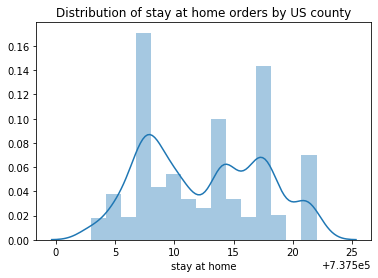

In [4]:
sns.distplot(counties_df["stay at home"].dropna())

plt.title("Distribution of stay at home orders by US county")

#I haven't figured out the date formatting here, but need to do that!

Text(0.5, 1.0, 'Cumulative cases since Feb')

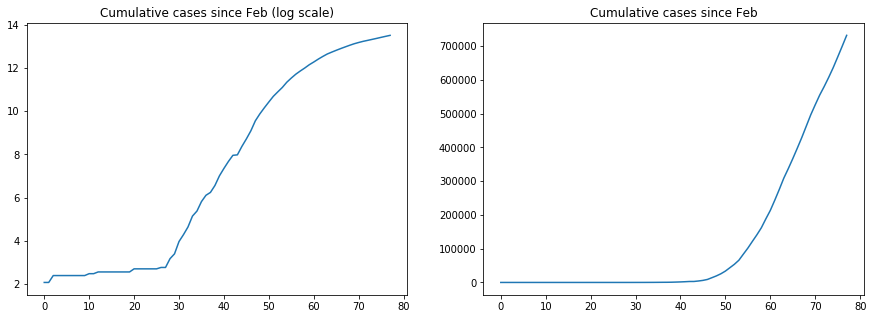

In [8]:
# Plot cumulative cases since February
us = time_cases_df.groupby("Country_Region").sum().iloc[:,15:].to_numpy().flatten()
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(0,len(us)), np.log(us))
ax[0].set_title("Cumulative cases since Feb (log scale)")
ax[1].plot(np.arange(0,len(us)), us)
ax[1].set_title("Cumulative cases since Feb")

Text(0.5, 1.0, 'Daily new cases since Feb')

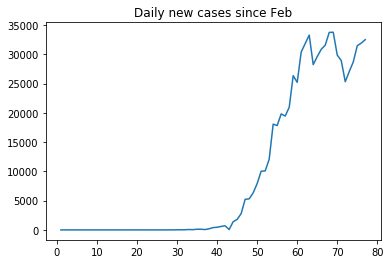

In [13]:
plt.plot(np.arange(1,len(us)), np.diff(us) )
plt.title("Daily new cases since Feb")

<BarContainer object of 77 artists>

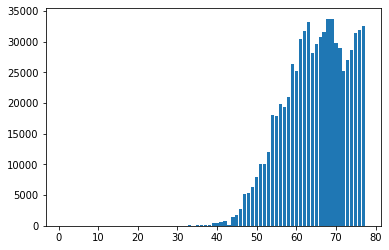

In [14]:
# Same as above, but in bar graph form

plt.bar(np.arange(1,len(us)), np.diff(us) )

Okay, now what I really want to do is understand how "stay at home orders" impact the new daily cases by county.

## Addressing the date time conversion on time series data

In [15]:
# The date objects were extremely annoying, so I built this function to convert them to pandas

def convert_ordinal_date_series_to_pd_date(series_object):
    """
    This function takes a series object of ordinal dates (days from the beginning of the 
    Gregorian calendar) and returns a pandas date time object series
    """
    
    #series_object = series_object.astype(int)
    k = []
    y = 0
    
    for ordinal_date in series_object:
        if np.isnan(ordinal_date) == True:
            y += 1
            k.append(np.nan)
            
        else:
            ordinal_date = int(ordinal_date)
            k.append(pd.to_datetime(datetime.datetime.fromordinal(ordinal_date)))
    print("Your series has", y, "NaNs. This function converts them to NaTs.")
    return pd.Series(k, index = series_object.index)

Testing function using Alameda County (closure on 3/17). Unfortunately, dataset seems to only include state shutdown orders; all counties have same stay at home orders, even though Alameda issued a county order earlier. But the function works.

In [16]:
index = counties_df[counties_df["CountyName"] == "Alameda"]["stay at home"].index
print("\n Date Alameda County closed:",convert_ordinal_date_series_to_pd_date(counties_df["stay at home"])[index].iloc[0])

#print("\n", counties_df[counties_df["StateName"]=="CA"]["stay at home"])

Your series has 490 NaNs. This function converts them to NaTs.

 Date Alameda County closed: 2020-03-19 00:00:00


In [17]:
counties_df["dem_to_rep_ratio"].head()

0    0.326656
1    0.253255
2    0.893106
3    0.278124
4    0.094317
Name: dem_to_rep_ratio, dtype: float64

In [ ]:
ids = ["FIPS","Admin2", "Province_State", "Country_Region"]
date_column_begin = 11
dates = pd.to_datetime(time_cases_df.columns[date_column_begin:])
df = time_cases_df[ids + list(time_cases_df.columns[date_column_begin:])]
df = df.melt(ids)
#date = pd.to_datetime(df["variable"])
df["date"] = date
df = df.rename(columns = {"value" : "cases"})

In [ ]:
table = df.pivot_table(values = "cases", index = [ "Province_State", "date"],  aggfunc=sum).reset_index()

table

In [ ]:
ca = table[table["Province_State"] == "California"]

J = np.array([np.nan])

ca.loc[:,"daily_new_cases"] = np.concatenate([J, np.diff(ca["cases"])])

ca

In [ ]:
threshold = 300
ca = ca[ca["cases"] >= threshold]
ca["days_since_threshold"] = np.arange(0,len(ca))

In [ ]:
plt.plot(ca["days_since_threshold"], ca["daily_new_cases"])

In [ ]:
lm = LinearRegression()

x = np.array(ca["days_since_threshold"]).reshape(-1,1)

y = np.array(ca["daily_new_cases"]).reshape(-1,1)

lm.fit(x,y)

y_hat = lm.predict(x)

$new.cases = \beta_0 + \beta_1~time$

In [ ]:
#fig, ax = plt.subplots(1,2, figsize=(15,5))

plt.plot(ca["days_since_threshold"], (ca["daily_new_cases"]))
plt.plot(ca["days_since_threshold"], y_hat)

In [ ]:
lm = LinearRegression()

ca["days_since_threshold^2"] = ca["days_since_threshold"]**2

x = ca[["days_since_threshold","days_since_threshold^2"]]

y = np.array(ca["daily_new_cases"]).reshape(-1,1)

lm.fit(x,y)

y_hat = lm.predict(x)

In [ ]:
plt.plot(ca["days_since_threshold"], (ca["daily_new_cases"]))
plt.plot(ca["days_since_threshold"], y_hat)

plt.title("Quadratic modeling of daily cases for California")
plt.ylabel("Daily new cases")
plt.xlabel("days since {} cases".format(threshold))

$new.cases = \beta_0 + \beta_1~time + \beta_2~time$

In this functional form, it easy to interpret $\beta_2$ as the deceleration rate. We can calculate state by state deceleration rates.
 
If we find that a variety of policies are indeed correlated with democratic leanings, can we also see if they explain the deceleration rate?

**Or can we try to use the decelerration rates to classify whether a state is democrat or republican?**

(Maybe we could think about democratic affiliation as an instrument because it is highly correlated with time (via a suite of policy interventions), but should be uncorrelated with new cases EXCEPT through the policies we're interested in.)